# HyperLSTM

# u3s_lab

# 1. Executive summary

The network concept proposes a new and revolutionary approach to the study and monitoring of water quality parameters.
The combination of convolutional and recurrent layers enables the model to make short-term predictions about the evolution of the parameters.

# 2. Imports and code dependencies

In [ ]:
!pip install rasterio --quiet
!pip install natsort --quiet
!pip install tensorflow_graphics --quiet
!pip install tensorflow_addons --quiet
!pip install visualkeras --quiet

In [ ]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import rasterio
from rasterio.plot import show
from PIL import Image
from natsort import natsorted
import random as rn
import tensorflow as tf
import tensorflow_graphics as tfg
import tensorflow_graphics.geometry.transformation as tfg_transformation
from tensorflow import keras
from keras import layers
from keras import optimizers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import visualkeras

SEED = 7231
os.environ['PYTHONHASHSEED'] = str(SEED)
rn.seed(29)
np.random.seed(13)
tf.random.set_seed(21)
tfds.disable_progress_bar()

# 3. Input/Output data

The simulation process used is the one provided by the challenge and output for every PRISMA image 16 patches with size of 256x256x50 saved as .tiff files with an UTM8 georeferenciation.

After some processing done through the function obtain_masks(), used to apply the NDCI hyperspectral index, the patches are converted to maps of dimension 256x256x1 with values ranging from -1 to 1.
All the images use the float32 bit depth.

The index is defined as:

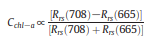

where Rrs represent the spectral reflectance ata that particular wavelength.

These maps are normalized by dividing every pixel that's non 0 by the maximum value found in the map and are then saved as numpy array .npy files.



In [ ]:
#Specify path to use
flag = "train"

if flag == 'train':
    data_path = '/content/drive/MyDrive/Colab_Notebooks/LSTM/train_tiffs'
    maps_path = '/content/drive/MyDrive/Colab_Notebooks/LSTM/train_maps'
elif flag == 'val':
    data_path = '/content/drive/MyDrive/Colab_Notebooks/LSTM/val_tiffs'
    maps_path = '/content/drive/MyDrive/Colab_Notebooks/LSTM/val_maps'
elif flag == 'test':
    data_path = '/content/drive/MyDrive/Colab_Notebooks/LSTM/test_tiffs'
    maps_path = '/content/drive/MyDrive/Colab_Notebooks/LSTM/test_maps'
else:
    raise Exception("Check your flag!")

To obtain a usable dataset, the structure provided in the figure needs to be respected.

One possible solution is to process all the images together and then manually divide to output following the scheme.

During the development, the files were already split according to the scheme and then the processing functions were ran 3 times to create the train, val and test datasets one by one.

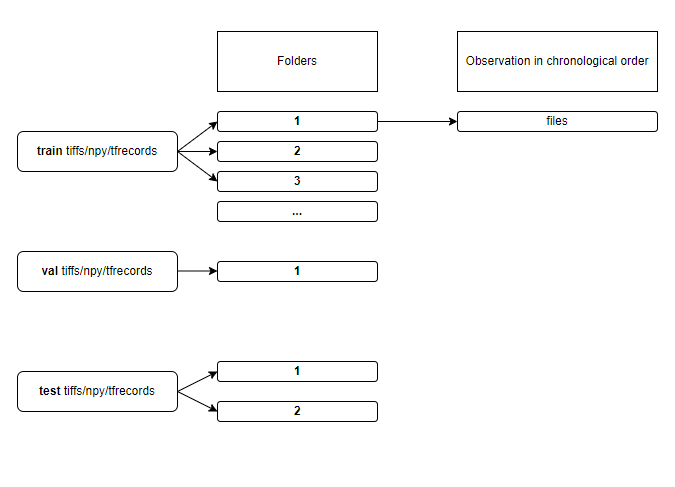

In [ ]:
debug_path = os.path.join(data_path, '1')

#Visualize tiff patches
tiff_files=natsorted(glob.glob(os.path.join(debug_path, '*.tiff')))

print(len(tiff_files))

for file in tiff_files:
    img = rasterio.open(file)
    show(img.read(25))

#Visualize patches' names
tiff_files

In [ ]:
def dataset_analysis(input_path):

    # Define some spectral bands of interest
    Bgreen = 11;      #560 nm
    BNir = 41;        #860 nm

    b708 = 26;
    b665 = 21;

    b754 = 30;

    max_value = 0
    min_value = 2
    mean_values = []
    std_values = []

    number_of_folders = len(next(os.walk(input_path))[1])

    for j in range(number_of_folders):

      # Get a list of TIFF files in the data path
      tiff_files = sorted(glob.glob(os.path.join(input_path, str(j+1), '*.tiff')))


      for file in tiff_files:
          img = rasterio.open(file)

          # NDCI - Normalized Difference Chlorophyll Index
          chloro_map = np.divide((img.read(b708)-img.read(b665)), (img.read(b708)+img.read(b665)));
          chloro_map = np.nan_to_num(chloro_map, nan=0.)

          # Water mask filtering
          mask = np.divide((img.read(Bgreen)-img.read(BNir)), (img.read(Bgreen)+img.read(BNir)));

          mask[mask < 0] = 0
          mask[mask > 0] = 1
          mask = np.nan_to_num(mask, nan=0.)


          land = np.where(mask == 0)
          chloro_map[land] = 0

          water = np.where(mask == 1)

          if len(chloro_map[water]) > 0:

              mean_values.append(np.mean(chloro_map[water]))
              std_values.append(np.std(chloro_map[water]))

              if np.max(chloro_map[water]) > max_value:
                  max_value = np.max(chloro_map[water])

              if np.min(chloro_map[water]) < min_value:
                  min_value = np.min(chloro_map[water])


    mean_value = np.mean(mean_values)
    std_value = np.mean(std_values)
    max_abs = np.max([max_dataset, np.abs(min_dataset)])

    return max_value, min_value, max_abs, mean_value, std_value


[max_dataset, min_dataset, max_value_dataset, mean_dataset, std_dataset] = dataset_analysis(data_path)

print(max_dataset)
print(min_dataset)
print(max_value_dataset)
print(mean_dataset)
print(std_dataset)



In [ ]:
def obtain_masks(input_path, output_path):

    bands = np.linspace(450,940,50)

    # Define some spectral bands of interest
    Bgreen = 11;      #560 nm
    BNir = 41;        #860 nm

    b708 = 26;
    b665 = 21;

    b754 = 30;

    number_of_folders = len(next(os.walk(input_path))[1])

    for j in range(number_of_folders):

      # Get a list of TIFF files in the data path
      tiff_files = sorted(glob.glob(os.path.join(input_path, str(j+1), '*.tiff')))


      for file in tiff_files:
          img = rasterio.open(file)

          # NDCI - Normalized Difference Chlorophyll Index
          chloro_map = np.divide((img.read(b708)-img.read(b665)), (img.read(b708)+img.read(b665)));
          chloro_map = np.nan_to_num(chloro_map, nan=0.)


          # Water mask filtering
          mask = np.divide((img.read(Bgreen)-img.read(BNir)), (img.read(Bgreen)+img.read(BNir)));

          mask[mask < 0] = 0
          mask[mask > 0] = 1
          mask = np.nan_to_num(mask, nan=0.)

          # Sets the pixels outside the water mask equal to 0
          land = np.where(mask == 0)
          chloro_map[land] = 0

          water = np.where(mask == 1)
          if len(chloro_map[water]) > 0:

              #norm by maximum value in each patch
              chloro_map[water] = chloro_map[water]*(1/np.max(chloro_map[water]))

          chloro_map = np.nan_to_num(chloro_map, nan=0.)

          # Debugging of nan values
          if np.isnan(chloro_map).any():

              print('There are NaN values')
              plt.imshow(chloro_map, vmin=-1, vmax = 1, cmap = 'jet')
              plt.colorbar()
              plt.show()


          #Save as numpy array files
          np.save(os.path.join(output_path, str(j+1),  os.path.splitext(os.path.basename(file))[0] + '_map'), chloro_map)

obtain_masks(data_path, maps_path)

In [ ]:
demap_path = os.path.join(maps_path, '1')

#Visualize masks
map_files = natsorted(glob.glob(os.path.join(demap_path, '*.npy')))
for map_file in map_files:
    # Load the image using numpy
    map = np.load(map_file)
    #print(np.shape(map))

    plt.imshow(map, vmin=-0.1, vmax = 0.5, cmap = 'jet')
    plt.colorbar()
    plt.show()

#Visualize masks' names
map_files

The .npy are then reopened an passed through the convert_to_tfrecord() function, which serialize the input data in TFRecord blocks.
Each blocks contains an entire sequence of spatio-temporal data training, consisting of 2 images used as timesteps and a third one used as the label that the model has to predict.

The delta time between two images of the same sequence ranges from 7 to 30 days and an effort has made to keep it as consistent as possible given the limited possibities offered by the image repository.

The model outputs a map detailing the parameter concentration with data ranging as well from -1 to 1: through empirical findings this can be linked to the actual concentration of the parameter studied.
The output map is of dimension 1x256x256x1 and can be viewed by setting the value of the first dimension.

In [ ]:
def convert_to_tfrecord(maps_path, flag):

    #Define the desired number of TFRecords files, one per folder
    number_of_tfrecords_files = len(next(os.walk(data_path))[1])

    number_of_patches = 16
    number_of_timesteps = 2


    #Choose where to save tfrecord
    if flag == "test":
        output_path = '/content/drive/MyDrive/Colab_Notebooks/LSTM/tfrecords_test/tfrecord_test{}.record'
    elif flag == "train":
        output_path = '/content/drive/MyDrive/Colab_Notebooks/LSTM/tfrecords_train/tfrecord_train{}.record'
    elif flag == "val":
        output_path = '/content/drive/MyDrive/Colab_Notebooks/LSTM/tfrecords_val/tfrecord_val{}.record'

    #Sequentially read the dataset and write TFRecords
    for i in range(number_of_tfrecords_files):
        # Create a TFRecord writer
        writer = tf.io.TFRecordWriter(output_path.format(i+1))

        #Iterate through the various folders
        folder_path = os.path.join(maps_path, str(i+1))

        # Get a list of files in the data path
        list_patches = []

        for k in range(number_of_patches):

            list_patches.append(sorted(glob.glob(os.path.join(folder_path, '*0' + str(k) + '_map.npy'))))

        for list_patch in list_patches:

            j = 0

            while j < (len(list_patch) - number_of_timesteps):

                #Load (number_of_timesteps + 1) images
                img1 = np.load(list_patch[j])
                img1_array=np.reshape(img1,[-1])

                img2 = np.load(list_patch[j+1])
                img2_array=np.reshape(img2,[-1])

                img3 = np.load(list_patch[j+2])
                img3_array=np.reshape(img3,[-1])

                #Get image parameters (same across the images)
                filename = list_patch[j].encode('utf8')    #contains the date of the first image
                timesteps = number_of_timesteps
                height = img1.shape[0]
                width = img1.shape[1]
                channels = 1

                # Create a feature dictionary
                feature = {
                        'image/filename': tf.train.Feature(bytes_list=tf.train.BytesList(value=[filename])),
                        'timesteps': tf.train.Feature(int64_list=tf.train.Int64List(value=[timesteps])),
                        'image/height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
                        'image/width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
                        'image/channels': tf.train.Feature(int64_list=tf.train.Int64List(value=[channels])),
                        'image1': tf.train.Feature(float_list=tf.train.FloatList(value=img1_array)),
                        'image2': tf.train.Feature(float_list=tf.train.FloatList(value=img2_array)),
                        'label': tf.train.Feature(float_list=tf.train.FloatList(value=img3_array)),
                }

                # Create an example protocol buffer
                example = tf.train.Example(features=tf.train.Features(feature=feature))

                # Serialize the example to a string
                serialized_example = example.SerializeToString()

                # Write the serialized example to the TFRecord file
                writer.write(serialized_example)

                j+=1

        writer.close()
        print('Successfully created the TFRecord file: {}'.format(output_path.format(i+1)))


# Convert TIFF files to TFRecords
convert_to_tfrecord(maps_path, flag)

# 4. ML algorithm and training

The algorithm used a supervised learning platform to compare the prevision of the model against an associated map obtained through the hyperspectral index.
Working with images, an hybrid CNN-LSTM has been implemented through the choice of the ConvLSTM2D keras layer.

The loss function used is the mean squared error while the optimizazion algorithm is ADAM.

A validation dataset has also been provided to assess the generalization capabilities of the network by studying the validation loss on new images.

The training uses two callback functions, one to slowly decrease the learning rate and the other to provide an early stop to the training if the validation loss start to increase.

In [ ]:
def load_tf_records(filepath):
    ''' This function will be used to load the TFRecord file from a given path'''

    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False

    filenames = tf.io.gfile.glob(filepath)
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=tf.data.AUTOTUNE).with_options(ignore_order)

    return dataset

def tf_records_file_features_description():
    image_feature_description = {

        'image/filename':tf.io.FixedLenFeature([],tf.string),
        'image/height':tf.io.FixedLenFeature([], tf.int64),
        'image/width':tf.io.FixedLenFeature([], tf.int64),
        'image/channels':tf.io.FixedLenFeature([], tf.int64),
        'timesteps':tf.io.FixedLenFeature([], tf.int64),
        'image1':tf.io.FixedLenFeature([256*256*1], tf.float32),
        'image2':tf.io.FixedLenFeature([256*256*1], tf.float32),
        'label':tf.io.FixedLenFeature([256*256*1], tf.float32),

    }
    return image_feature_description

def decode_dataset(example_proto):
    features=tf.io.parse_single_example(example_proto, tf_records_file_features_description())
    angle = tf.random.uniform([], minval = -np.pi, maxval = np.pi)

    filename=features['image/filename']
    height=features['image/height']
    width=features['image/width']
    channels=features['image/channels']
    timesteps=features['timesteps']


    patch1=tf.reshape(features['image1'],[1, height, width, channels])
    patch1=tfa.image.rotate(patch1, angle)

    patch2=tf.reshape(features['image2'],[1, height, width, channels])
    patch2=tfa.image.rotate(patch2, angle)

    patches = tf.concat([patch1, patch2], 0)

    label=tf.reshape(features['label'],[1, height, width, channels])
    label=tfa.image.rotate(label, angle)

    return patches, label


In [ ]:
flag = "train"

#Define a batch size
batch_size = 8
epochs = 50
AUTO = tf.data.AUTOTUNE

# Size of the random crops to be used during training.
input_img_size = (2, 256, 256, 1)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

#Decoding of the various datasets

if flag == "train":

      train_dataset_path='/content/drive/MyDrive/Colab_Notebooks/LSTM/tfrecords_train/*.record'
      train_dataset=load_tf_records(train_dataset_path).map(decode_dataset, num_parallel_calls=AUTO).repeat().batch(batch_size).prefetch(AUTO)

      val_dataset_path='/content/drive/MyDrive/Colab_Notebooks/LSTM/tfrecords_val/*.record'
      val_dataset=load_tf_records(val_dataset_path).map(decode_dataset, num_parallel_calls=AUTO).repeat().batch(batch_size).prefetch(AUTO)

      dataset_size=len(list(load_tf_records(train_dataset_path)))
      train_steps=dataset_size//batch_size

      val_size=len(list(load_tf_records(val_dataset_path)))
      val_steps=val_size//batch_size


test_dataset_path='/content/drive/MyDrive/Colab_Notebooks/LSTM/tfrecords_test/*.record'
test_dataset=load_tf_records(test_dataset_path).map(decode_dataset, num_parallel_calls=AUTO).batch(batch_size).prefetch(AUTO)

In [ ]:
import math
from matplotlib import pyplot as plt

start_lr = 0.01
alpha=0.001 #final lr as a faction of the initial one
decay_steps=epochs

def lr_scheduler(epoch, start_lr):
    cosine_decay = 0.5 * (1 + tf.cos(np.pi * epoch / (decay_steps-1)))
    decayed = (1 - alpha) * cosine_decay + alpha
    return start_lr * decayed

#Define a keras callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_scheduler(epoch,start_lr), verbose=1)
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=8)

#Plot learning rate scheduling
rang = np.arange(epochs)
y = [lr_scheduler(x,start_lr) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [ ]:
def get_convLSTM_puremodel(
    filters=64,
    gamma_initializer=gamma_init,
    name=None,
):

      # Construct the input layer with no definite frame size.
      img_input = layers.Input(shape=input_img_size, name=name + "_img_input")

      # We will construct 3 `ConvLSTM2D` layers with batch normalization,
      # followed by a `Conv3D` layer for the spatiotemporal outputs.
      x = layers.ConvLSTM2D(
          filters=filters,
          kernel_size=(5, 5),
          kernel_initializer=kernel_init,
          padding="same",
          return_sequences=True,
          activation="relu",
      )(img_input)
      x = layers.BatchNormalization()(x)
      x = layers.ConvLSTM2D(
          filters=filters,
          kernel_size=(3, 3),
          kernel_initializer=kernel_init,
          padding="same",
          return_sequences=True,
          activation="relu",
      )(x)
      x = layers.BatchNormalization()(x)
      x = layers.ConvLSTM2D(
          filters=filters,
          kernel_size=(1, 1),
          kernel_initializer=kernel_init,
          padding="same",
          return_sequences=True,
          activation="relu",
      )(x)
      x = layers.Conv3D(
          filters=1, kernel_size=(3, 3, 3), strides=(2, 1, 1), activation="tanh", padding="same"
      )(x)


      # Next, we will build the complete model and compile it.
      model = keras.models.Model(img_input, x, name=name)
      return model


In [ ]:
#Define the model
network = get_convLSTM_puremodel(name="rete_convLSTM")

network.compile(loss='mse', optimizer='adam')
network.summary()


In [ ]:
#Visualize the NN
tf.keras.utils.plot_model(network,show_shapes=True)
visualkeras.layered_view(network, legend =True, scale_xy=1, scale_z=2, max_z=200, max_xy = 50)

In [ ]:
history=network.fit(train_dataset,
                validation_data = val_dataset,
                epochs=epochs,
                steps_per_epoch=train_steps,
                validation_steps=val_steps,
                callbacks=[early_stopping, lr_callback],
                )

network.save('/content/drive/MyDrive/Colab_Notebooks/LSTM/network_mse_rot_meanstddataset.keras')

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0.00, 2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 5. Inference

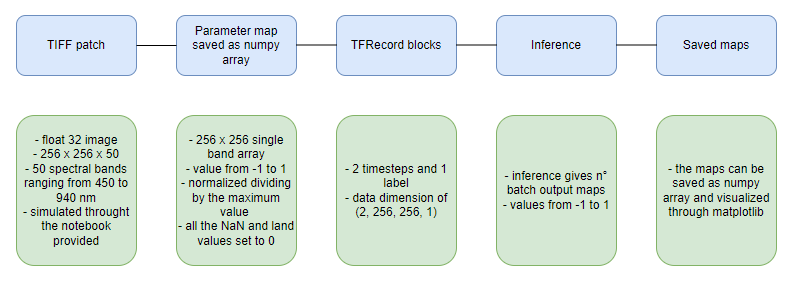

In [ ]:
network = tf.keras.saving.load_model('/content/drive/MyDrive/Colab_Notebooks/LSTM/network_mse_rot_meanstddataset.keras')

In [ ]:
predictions = network.predict(test_dataset)

In [ ]:
print(np.shape(predictions))

for prediction in predictions:

      index = np.where(prediction[0,:,:,:] != 0)
      prediction[0,:,:,:][index] = prediction[0,:,:,:][index]*0.0302 -0.0815

      plt.imshow(prediction[0,:,:,:], vmin=-0.1, vmax = 0.5, cmap = 'jet')
      plt.colorbar()
      plt.show()





In [ ]:
for entry in test_dataset.unbatch():
        [patches, label] = entry

        plt.imshow(label[0,:,:,:], vmin=-1, vmax = 1, cmap = 'jet')
        plt.colorbar()
        plt.show()

Provide information on the computational cost (RAM/CPUs currently used)

# 6. Validation

The hyperspectral index used has been validated with in-situ data through various indipendent research papers written over the years. [[1]](https://www.researchgate.net/publication/259873574_Normalized_difference_chlorophyll_index_A_novel_model_for_remote_estimation_of_chlorophyll-a_concentration_in_turbid_productive_waters) [[2]](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5579528/)

The training process was validated through the study of the loss and the validation loss function: they both return very low values, ranging from 10e-3 to 10e-4.

A known issue is the limited spatial and temporal coverage of the dataset used.
Every images has also a lot of pixel that with the application of the hyperspectral index get set to 0 and this generates an imbalance between the emtpy and informative pixels hindering the capability of the network to fully concentrate on the informative pixel.

A deeper study on how to minimize the effect of this null values could be conducted to improve the performance of the model.